# PHYS20762 - Project - Measuring Drop Spreading Law

Robert Hartley
University of Manchester  
February 2022

Initialise our Python interpreter

In [1]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

![](./img/bee.png)
## Experimental Data

This is data that we are working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [2]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

Plotting the experimental data.

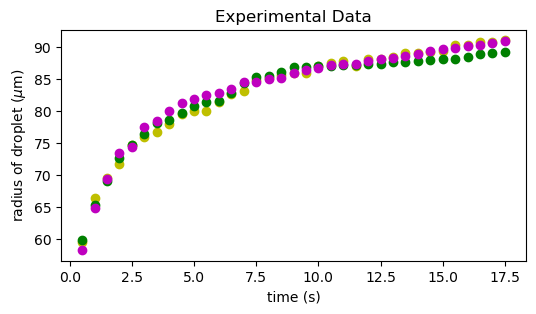

In [13]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
plt.plot(time, radius_data1, "yo")
plt.plot(time, radius_data2, "go")
plt.plot(time, radius_data3, "mo")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("radius of droplet ($\mu$m)")
plt.title("Experimental Data")
# displaying the plot
plt.show()

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 



In [4]:
VOLUME = 7.6 * 10 ** (-15) #7.6 pL into m^3 - SI units
#Initalizing arrays
speed_1 = []
speed_2 = []
speed_3 = []
contact_1 = []
contact_2 = []
contact_3 = []
#Putting radius data into SI units - m
SI_radius_data1 = np.multiply(radius_data1, 10 ** -6)
SI_radius_data2 = np.multiply(radius_data2, 10 ** -6)
SI_radius_data3 = np.multiply(radius_data3, 10 ** -6)

def calc_height(radius, vol = VOLUME):
    '''Function to find the height of a droplet of radius R.
    Returns the real root of a cubic function.
    Parameters:
    radius : value of radius of droplet at time t : float
    vol : constant volume : float
    -----
    Returns:
    height : real root of cubic : float
    '''
    height = np.roots([1, 0, 3 * radius ** 2, -6 / np.pi * vol])
    return height[np.isreal(height)][0]

def calc_angle(radius, height):
    '''Function to find the contact angle of a droplet of radius R and height H.
    Parameters:
    radius : value of radius of droplet at time t : float
    height : height of droplet at time t : float
    -----
    Returns:
    angle : absolute value of contact angle : float
    '''
    angle = np.pi / 2 - np.arctan((radius ** 2 - height ** 2) /  (2 * height * radius))
    return np.abs(angle)

for index in range(0, len(radius_data1)-1): #For loop that goes through each expiermental data loop.
    #This loop ignores the last data point as it has a lot less statistical weight.
    speed_1.append((SI_radius_data1[index + 1] - SI_radius_data1[index]) / 0.5) #Difference in radius over time difference
    speed_2.append((SI_radius_data2[index + 1] - SI_radius_data2[index]) / 0.5)
    speed_3.append((SI_radius_data3[index + 1] - SI_radius_data3[index]) / 0.5)
    
    #Calcualte contact angle
    height = calc_height(SI_radius_data1[index])
    contact_1.append(calc_angle(SI_radius_data1[index], height))

    height = calc_height(SI_radius_data2[index])
    contact_2.append(calc_angle(SI_radius_data2[index], height))
    
    height = calc_height(SI_radius_data3[index])
    contact_3.append(calc_angle(SI_radius_data3[index], height))

#Stacking numpy arrays for ease when plotting.
speeds = np.empty((0, 34))
speeds = np.vstack((speeds, speed_1))
speeds = np.vstack((speeds, speed_2))
speeds = np.vstack((speeds, speed_3))
speeds = speeds * 10 ** 6 #Put speeds back into micro ms^-1
contact_angles = np.empty((0,34))
contact_angles = np.vstack((contact_angles, contact_1))
contact_angles = np.vstack((contact_angles, contact_2))
contact_angles = np.vstack((contact_angles, contact_3))


Let's plot these results to see what they look like:

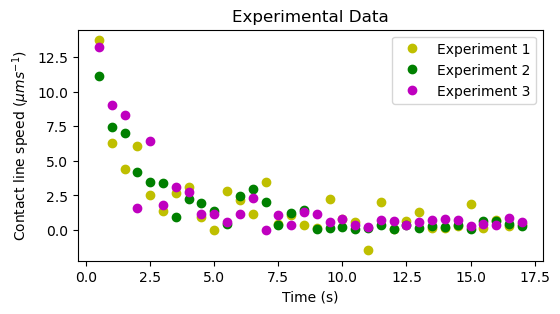

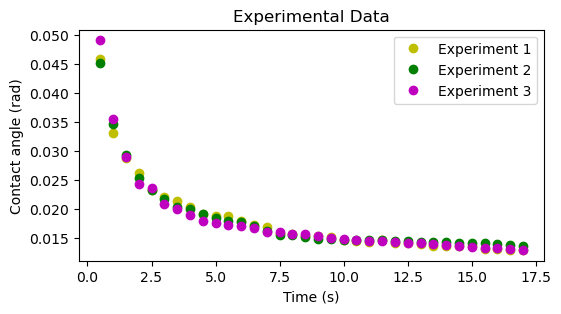

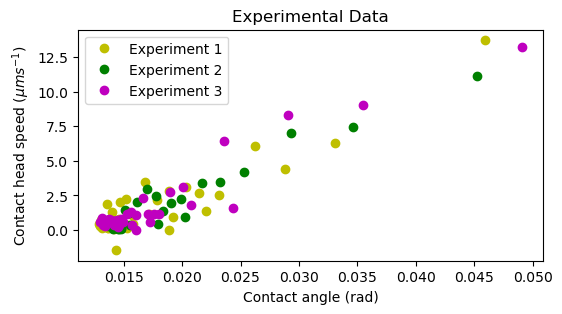

In [14]:
#Tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
#Plotting data from experimental runs 1-3:
colours = ["yo", "go", "mo"]
labels = ['Experiment 1', 'Experiment 2', 'Experiment 3']
for index, speed in enumerate(speeds):
    plt.plot(time[:-1], speed, colours[index], label=labels[index])
# setting axis labels & figures 
plt.xlabel("Time (s)")
plt.ylabel(r'Contact line speed ($\mu ms^{-1}$)')
plt.title("Experimental Data")
plt.legend()

plt.show()

for index, contact in enumerate(contact_angles):
    plt.plot(time[:-1], contact, colours[index], label=labels[index])
    
# setting axis labels & figures 
plt.xlabel("Time (s)")
plt.ylabel("Contact angle (rad)")
plt.title("Experimental Data")
plt.legend()
# displaying the plot
plt.show()
for index in range(0,3):
    plt.plot(contact_angles[index], speeds[index], colours[index], label=labels[index])

plt.xlabel("Contact angle (rad)")
plt.ylabel(r'Contact head speed ($\mu ms^{-1}$)')
plt.title("Experimental Data")
plt.legend()
# displaying the plot
plt.show()


The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

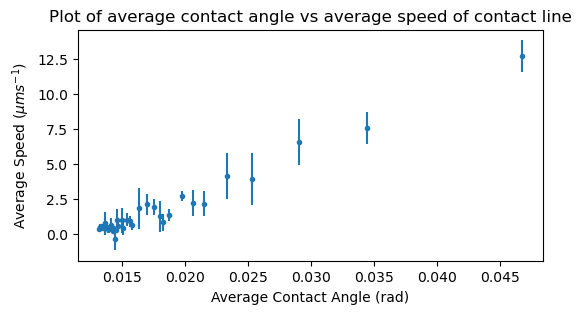

In [15]:
#Averaging the 3 experimental data into one array
av_speed = np.mean(np.array(speeds), axis=0)
av_contact = np.mean(np.array(contact_angles), axis=0)
#Finding standard deviation at each time
av_speed_std = np.std(np.array(speeds), axis=0)
av_contact_std = np.std(np.array(contact_angles), axis=0)

#Plot data
plt.errorbar(av_contact, av_speed, yerr=av_speed_std, fmt='.')
plt.xlabel("Average Contact Angle (rad)")
plt.ylabel(r'Average Speed ($\mu ms^{-1}$)')
plt.title("Plot of average contact angle vs average speed of contact line")
plt.show()


![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [16]:
#Squaring and Cubing contact angles to get a linear relationship
deGen_contact = av_contact ** 2
coxV_contact = av_contact ** 3

def linear_fit(x_data, y_data):
    """Function to fit a straight line between x and y data.
    Parameters :
    x_data : contact angles in a certain relationship : array of floats
    y_data : contact line speed : array of floats
    -----
    Returns:
    y_fit : y values from our fitted straight line : array of floats
    coef : array of coefficients of straight line : array of floats
    err_coef1 : uncertainty on first coefficient : float
    err_coef2 : uncertainty on second coefficient : float"""
    coef, covr = np.polyfit(x_data, y_data, 1, cov=True)
    err_coef1 = np.sqrt(covr[0][0])
    err_coef2 = np.sqrt(covr[1][1])
    y_fit = coef[0]*x_data + coef[1]
    return y_fit, coef, err_coef1, err_coef2

#Fitting y = m*x + c to speed and squared contact angles.
deGen_fit, deGen_coef, deGen_coef_err1, deGen_coef_err2 = linear_fit(deGen_contact, av_speed)
#Calculating equilibrium angle from value of +c
deGen_eqlbrm_angle = np.sqrt(-deGen_coef[1] / deGen_coef[0])
#Calculating error on equilibrium angle in quadrature.
#Where theta_0 = sqrt(-c/U_0)
deGen_eqlbrm_err = np.power(((deGen_coef_err2 / deGen_coef[1]) ** 2
                    + (deGen_coef_err1 / deGen_coef[0]) ** 2) / 2, 1/2) * deGen_eqlbrm_angle

print("For the de Gennes law we have :\nU_0 = {:.2g} +/- {:.2g} m/s\n".format(deGen_coef[0] * 10 ** -6, deGen_coef_err1 * 10 ** -6)+
      "Equilibrium angle = {:.2g} +/- {:.2g} rad".format(deGen_eqlbrm_angle, deGen_eqlbrm_err))

coxV_fit, coxV_coef, coxV_coef_err1, coxV_coef_err2 = linear_fit(coxV_contact, av_speed)


#Calculating error on equilibrium angle in quadrature.
#Where theta_0 = cbrt(-c/U_0)
coxV_eqlbrm_angle = np.cbrt(-coxV_coef[1] / coxV_coef[0])
coxV_eqlbrm_err = np.power(((coxV_coef_err2 / coxV_coef[1] )** 2 
                            + (coxV_coef_err1 / coxV_coef[0]) ** 2) / 3, 1/2) * coxV_eqlbrm_angle


print("\nFor the Cox-Voinov law we have :\nU_0 = {:.2g} +/- {:.2g}  m/s\n".format(coxV_coef[0] * 10 ** -6, coxV_coef_err1 * 10 ** -6)+
      "Equilibrium angle = {:.2g} +/- {:.2g} rad".format(coxV_eqlbrm_angle, coxV_eqlbrm_err))


For the de Gennes law we have :
U_0 = 0.0066 +/- 0.00026 m/s
Equilibrium angle = 0.0096 +/- 0.0016 rad

For the Cox-Voinov law we have :
U_0 = 0.13 +/- 0.0087  m/s
Equilibrium angle = -0.016 +/- -0.0029 rad


## Displaying the corresponding fits  

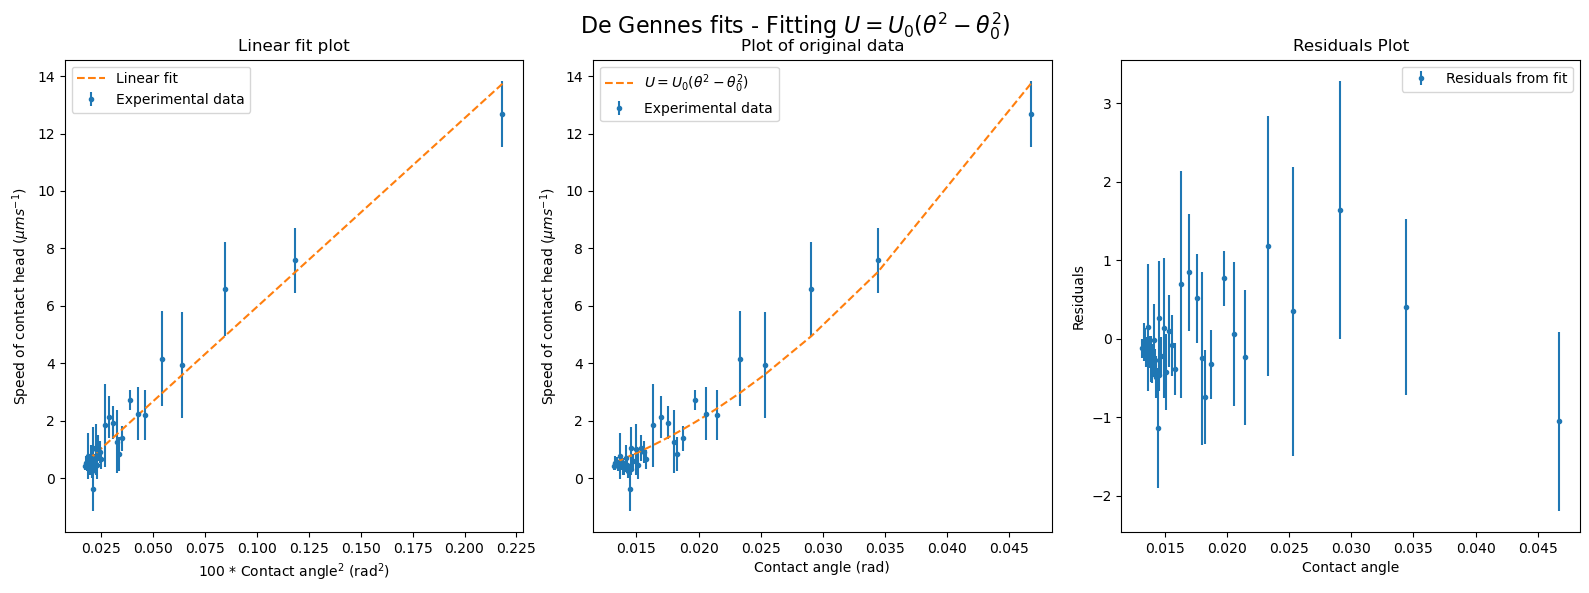

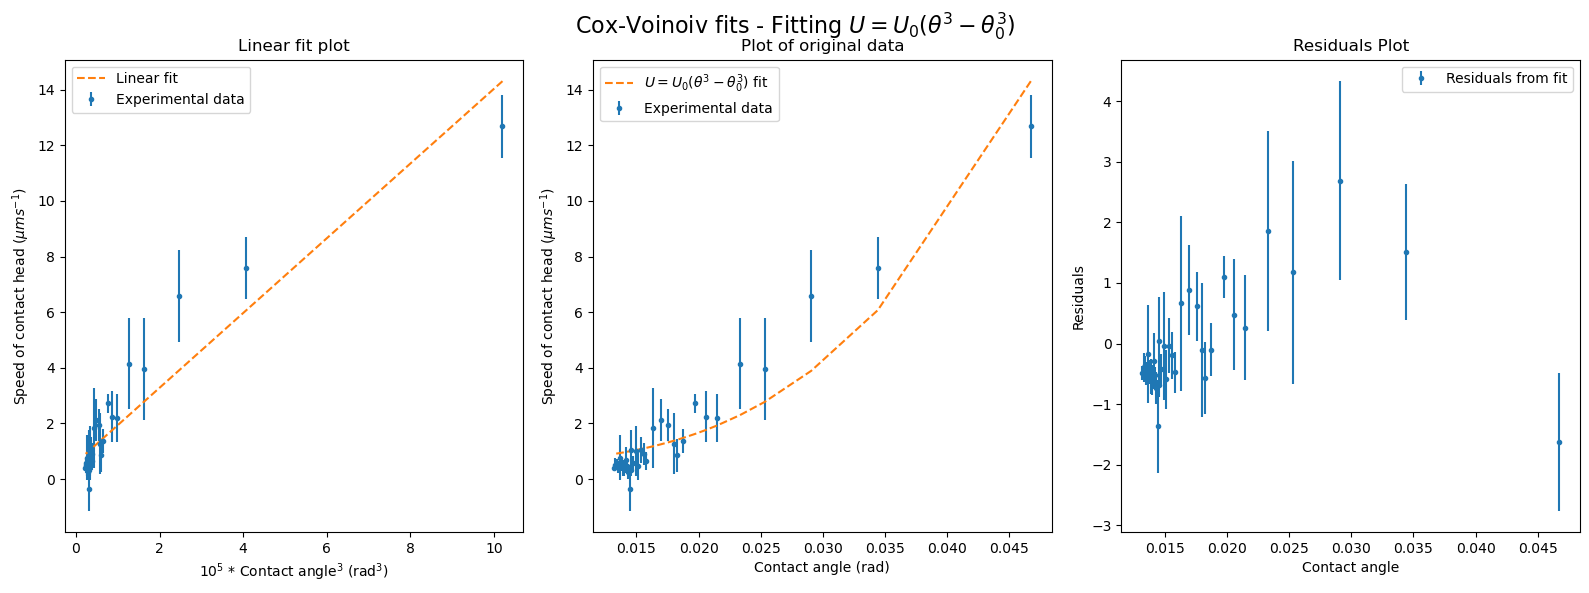

In [19]:
#Editing figure size to make the plots readable
plt.rcParams["figure.figsize"] = (16,6)
#Initialise first figure with 3 subplots.
fig,(ax1, ax2, ax3) = plt.subplots(1,3)

fig.suptitle(r'De Gennes fits - Fitting $U = U_0(\theta^2 - \theta_0^2)$', fontsize = 16)

#Plot linear fit
ax1.errorbar(100*deGen_contact, av_speed, yerr = av_speed_std, fmt='.', label = 'Experimental data')
ax1.plot(100*deGen_contact, deGen_fit, '--', label = 'Linear fit')
ax1.set(xlabel = '100 * Contact angle${}^2$ (rad${}^2$)')
ax1.set(ylabel = r'Speed of contact head ($\mu ms^{-1}$)')
ax1.legend()
#Plot Square relationship
fit_1 = deGen_coef[0]*(av_contact**2 - deGen_eqlbrm_angle**2)
ax2.errorbar(av_contact, av_speed, yerr = av_speed_std, fmt='.', label = 'Experimental data')
ax2.plot(av_contact, fit_1, '--', label = r'$U = U_0(\theta^2 - \theta_0^2)$')
ax2.set(xlabel = 'Contact angle (rad)')
ax2.set(ylabel = r'Speed of contact head ($\mu ms^{-1}$)')
ax2.legend()

#Plot residual plot
ax3.errorbar(av_contact, av_speed - deGen_fit, yerr = av_speed_std, fmt='.', label='Residuals from fit')
ax3.set(xlabel = 'Contact angle')
ax3.set(ylabel = 'Residuals')
ax3.legend()

fig.tight_layout()
#Subplot titles
ax1.title.set_text('Linear fit plot')
ax2.title.set_text('Plot of original data')
ax3.title.set_text('Residuals Plot')

plt.show()

#Initalize another figure for Cox Voinoiv fit
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle(r'Cox-Voinoiv fits - Fitting $U = U_0(\theta^3 - \theta_0^3)$', fontsize = 16)


ax1.errorbar(10 ** 5 * coxV_contact, av_speed, yerr=av_speed_std, fmt='.', label='Experimental data')
ax1.plot(10 ** 5 * coxV_contact, coxV_fit, '--', label='Linear fit')
ax1.set(xlabel = r'$10^5$ * Contact angle${}^3$ (rad${}^3$)')
ax1.set(ylabel = r'Speed of contact head ($\mu ms^{-1}$)')
ax1.legend()

fit_2 = coxV_coef[0]*(av_contact**3 - coxV_eqlbrm_angle**3)
ax2.errorbar(av_contact, av_speed, yerr=av_speed_std, fmt='.', label='Experimental data')
ax2.plot(av_contact, fit_2, '--', label=r'$U = U_0(\theta^3 - \theta_0^3)$ fit')
ax2.set(xlabel=r'Contact angle (rad)')
ax2.set(ylabel=r'Speed of contact head ($\mu ms^{-1}$)')
ax2.legend()

ax3.errorbar(av_contact, av_speed - coxV_fit, yerr = av_speed_std, fmt='.', label='Residuals from fit')
ax3.set(xlabel='Contact angle')
ax3.set(ylabel='Residuals')
ax3.legend()

fig.tight_layout() #No overlap
#Sub plot titles
ax1.title.set_text('Linear fit plot')
ax2.title.set_text('Plot of original data')
ax3.title.set_text('Residuals Plot')

plt.show()




![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. The case is further strengthened using the residual plots. 

In [20]:
# write your code here & but also expand the description above
def chi_squared(y_data, y_fit, y_err, n):
    """Function to calaculate reduced chi square from a fit.
    Parameters:
    y_data : y values from experimental data : array of floats
    y_fit : y values from fitted data : array of floats
    y_err : standard deviation on each y value : array of floats
    n : number of dimension : integer
    ---
    Returns:
    reduced chi squared : float"""
    return(sum(((y_data - y_fit)/y_err)**2)/(len(y_data)-n))


deGen_chi = (chi_squared(av_speed, deGen_fit, av_speed_std, 1))
coxV_chi = (chi_squared(av_speed, coxV_fit, av_speed_std, 1))



![](./img/bee.png)
## Drop Spreading Law Is

The results of the chi-squared analysis suggest that the "" law is a better fit for the behaviour of the spreading drop because ...  

In [21]:
#Work out which chi squared is closest to 1
if np.abs(coxV_chi - 1) < np.abs(deGen_chi - 1):
    spread_law = 'Cox-Voinov law'
    spread_chi = coxV_chi
    not_spread_law = 'De Gennes law'
    not_spread_chi = deGen_chi
else:
    not_spread_law = 'Cox-Voinov law'
    not_spread_chi = coxV_chi
    spread_law = 'De Gennes law'
    spread_chi = deGen_chi

print("The results of the chi-squared analysis suggests that the {} is a better fit for the behaviour".format(spread_law),
      "of the spreading drop because its value of the reduced chi squared, {:.3f},".format(spread_chi),
      "was closer to 1 than the {}'s reduced chi value of {:.3f}.".format(not_spread_law, not_spread_chi))
      
      
      
      

The results of the chi-squared analysis suggests that the De Gennes law is a better fit for the behaviour of the spreading drop because its value of the reduced chi squared, 1.037, was closer to 1 than the Cox-Voinov law's reduced chi value of 3.389.
